# Importing Library 

In [81]:
import pandas as pd 
import numpy as np 
import re 
import nltk 
from nltk.corpus import stopwords
from numpy import array
import seaborn as sns 
import matplotlib.pylab as plt


from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation,Dropout,Dense
from keras.layers import Flatten,GlobalMaxPooling1D,Embedding,Conv1D,LSTM
from sklearn.model_selection import train_test_split

# Load Dataset

In [82]:
#Load The Dataset 
df=pd.read_csv('IMDB_Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# EDA

In [83]:
# check the shape 
df.shape

(50000, 2)

In [84]:
# checking for missing value 
df.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

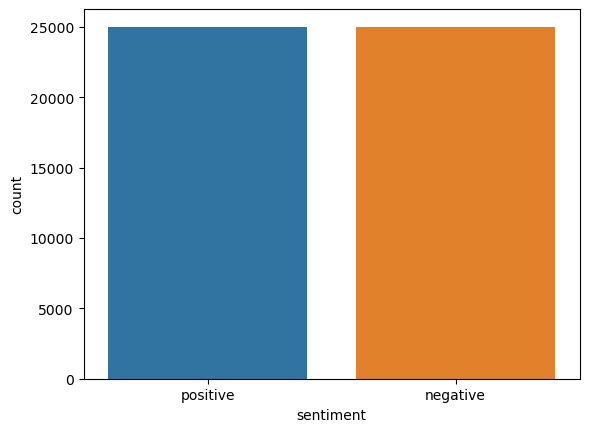

In [85]:
sns.countplot(x='sentiment',data=df)

# Data Preprocessing 

In [86]:
# Check of how the Text is written (Any Example that you Want)
df['review'][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [87]:
# Remove the Tags
Tag_RE=re.compile(r'<[^>]+>')

def remove_tags(text):
    return Tag_RE.sub(' ',text) #Replaced it with white spaces 

In [88]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [89]:
def preprocess_text(sen):
    #cleans texts data up ,leaving only 2 or more char a long non-stopwords composed of A-Z & a-z only in lower case

    sentence = sen.lower()

    # remove the tages
    sentance=remove_tags(sen)

    # remove punctuations and numbers 
    sentance = re.sub(r'[^a-zA-Z]',' ',sentance)
    #single character removal 
    sentance=re.sub(r'\s+[a-zA-z]\s+' ,' ',sentance) # for example Mark's when we remove the s it will replaced with empty strings 
    
    #remove Multiple Spaces 
    sentance=re.sub(r'\s+',' ',sentance)  # replace the single char by empty space 
    # remove stopwords 
    pattern=re.compile(r'\b(' + r'|' .join(stopwords.words('english'))+r')\b\s+')
    sentance=pattern.sub(" " ,sentance) 

    return sentance


In [90]:
# Calling the preprocessing_text function on df 
x=[]
sentences=list(df['review'])
for sen in sentences:
    x.append(preprocess_text(sen))
    

In [91]:
# show sample 
x[2]

'I thought   wonderful way  spend time   hot summer weekend sitting   air conditioned theater  watching light hearted comedy The plot  simplistic   dialogue  witty   characters  likable even  well bread suspected serial killer While  may  disappointed   realize    Match Point Risk Addiction thought   proof  Woody Allen  still fully  control   style many  us  grown  love This     laughed  one  Woody comedies  years dare say decade While  never  impressed  Scarlet Johanson    managed  tone   sexy image  jumped right  average  spirited young woman This may    crown jewel   career    wittier  Devil Wears Prada   interesting  Superman great comedy  go see  friends '

In [92]:
# convert sentiment label to 0 and 1 
y=df['sentiment']

y=np.array(list(map(lambda x: 1  if x=='positive' else 0 ,y)))


In [93]:
# Train - Test split 
X_train,X_test ,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42)

# train goes into model 
# test goes into model performance 


# Preparing the Embedding layer 

convert the sentances  to Numaric  

In [94]:
# in word index dict each word  in courpus is key  and value is the index of that key |
word_tokenizer=Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train=word_tokenizer.texts_to_sequences(X_train)
X_test=word_tokenizer.texts_to_sequences(X_test)

In [95]:
# Adding 1 to store the dimension for words for which no pretrained word embedding exist  > 90855 uniqe words
vocab_length=len(word_tokenizer.word_index)+1
vocab_length

90855

In [96]:
# padding all reviews to fixed length 100

maxlen=100
X_train=pad_sequences(X_train,padding='post',maxlen=maxlen)
X_test=pad_sequences(X_test,padding='post',maxlen=maxlen)


In [97]:
# now we use Glove Embaddding and create an Embedding Dictionary 
from numpy import asarray
from numpy import zeros

embedding_dictionary=dict()
glove_file=open('a2_glove.6B.100d.txt',encoding='utf8')

for line in glove_file:
    recordes=line.split()
    word=recordes[0]
    vectors_dimintions=asarray(recordes[1:],dtype='float32')
    embedding_dictionary[word]=vectors_dimintions
glove_file.close()    

In [98]:
#create embadding matrix having 100 columns
#containing 100-dimensional GloVe word embedding for all words in our corpus.

embedding_matrix=zeros((vocab_length,100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector=embedding_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index]=embedding_vector
    

In [99]:
embedding_matrix.shape

(90855, 100)

# Model Traning  

### Simple Neural Network 

In [100]:
# Neural Network Architecture 

snn_model=Sequential()

embedding_layar=Embedding(vocab_length,100,weights=[embedding_matrix],input_length=maxlen , trainable=False)
snn_model.add(embedding_layar)
snn_model.add(Flatten())
snn_model.add(Dense(1,activation='sigmoid'))


In [101]:
# Model Compile 
snn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
print(snn_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          9085500   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 9095501 (34.70 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9085500 (34.66 MB)
_________________________________________________________________
None


In [102]:
# Model Training 
snn_model_history=snn_model.fit(X_train,y_train,batch_size=128,epochs=6,verbose=1,validation_split=(0.2))


Epoch 1/6
250/250 [==============================] - 2s 5ms/step - loss: 0.5602 - acc: 0.7120 - val_loss: 0.5095 - val_acc: 0.7554
Epoch 2/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4521 - acc: 0.7933 - val_loss: 0.5103 - val_acc: 0.7590
Epoch 3/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4139 - acc: 0.8161 - val_loss: 0.5137 - val_acc: 0.7688
Epoch 4/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3912 - acc: 0.8279 - val_loss: 0.5110 - val_acc: 0.7661
Epoch 5/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3790 - acc: 0.8325 - val_loss: 0.5264 - val_acc: 0.7673
Epoch 6/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3627 - acc: 0.8420 - val_loss: 0.5366 - val_acc: 0.7623


In [103]:
# prediction on testset 

score=snn_model.evaluate(X_test,y_test,verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5448 - acc: 0.7533


In [104]:
#Model Performance 
print("Test score:" , score[0])
print("Test Accuracy:" , score[1])

Test score: 0.5448005199432373
Test Accuracy: 0.7533000111579895


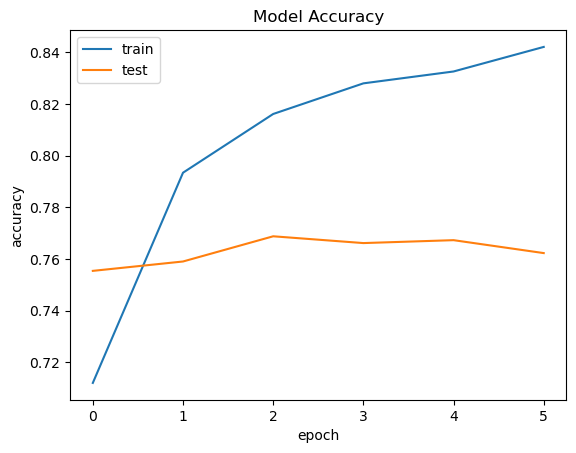

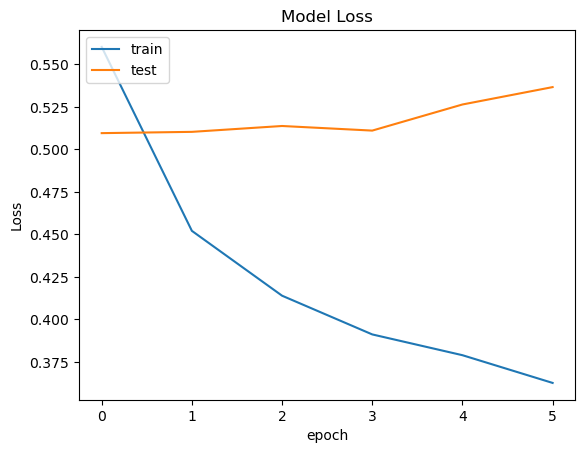

In [105]:
# Model performance Charts 
plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')


plt.show()

### Since we got an overfit of the model we going to try another way  

# Convolutional Neural Network 

In [106]:
# Neural Network Architecture 
cnn_model=Sequential()

embedding_layar=Embedding(vocab_length,100,weights=[embedding_matrix],input_length=maxlen , trainable=False)
cnn_model.add(embedding_layar)

cnn_model.add(Conv1D(128,5,activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1,activation='sigmoid'))

In [107]:
# Model Compile
cnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          9085500   
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9149757 (34.90 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9085500 (34.66 MB)
_________________________________________________________________
None


In [108]:
# Model Training 
cnn_model_history=cnn_model.fit(X_train,y_train,batch_size=128,epochs=6,verbose=1,validation_split=(0.2))

Epoch 1/6
250/250 [==============================] - 5s 16ms/step - loss: 0.5065 - acc: 0.7543 - val_loss: 0.3889 - val_acc: 0.8321
Epoch 2/6
250/250 [==============================] - 4s 16ms/step - loss: 0.3500 - acc: 0.8513 - val_loss: 0.3525 - val_acc: 0.8421
Epoch 3/6
250/250 [==============================] - 5s 19ms/step - loss: 0.2965 - acc: 0.8786 - val_loss: 0.3456 - val_acc: 0.8479
Epoch 4/6
250/250 [==============================] - 5s 21ms/step - loss: 0.2503 - acc: 0.9044 - val_loss: 0.3623 - val_acc: 0.8382
Epoch 5/6
250/250 [==============================] - 5s 21ms/step - loss: 0.2104 - acc: 0.9262 - val_loss: 0.3290 - val_acc: 0.8566
Epoch 6/6
250/250 [==============================] - 5s 20ms/step - loss: 0.1755 - acc: 0.9448 - val_loss: 0.3363 - val_acc: 0.8524


In [109]:
# prediction on testset 
score=cnn_model.evaluate(X_test,y_test,verbose=1)

313/313 [==============================] - 2s 5ms/step - loss: 0.3395 - acc: 0.8558


In [110]:
#Model Performance 
print("Test score:" , score[0])
print("Test Accuracy:" , score[1])

Test score: 0.3394785523414612
Test Accuracy: 0.8557999730110168


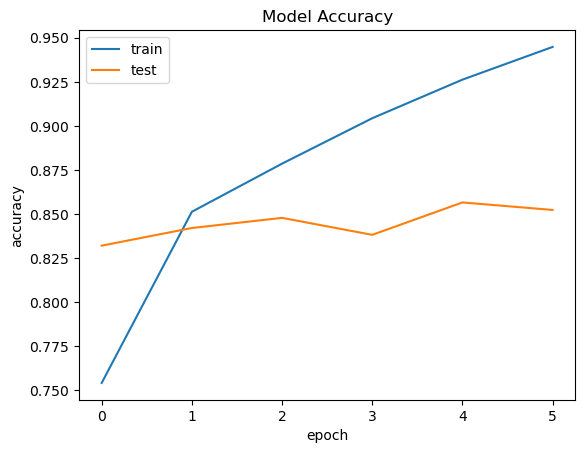

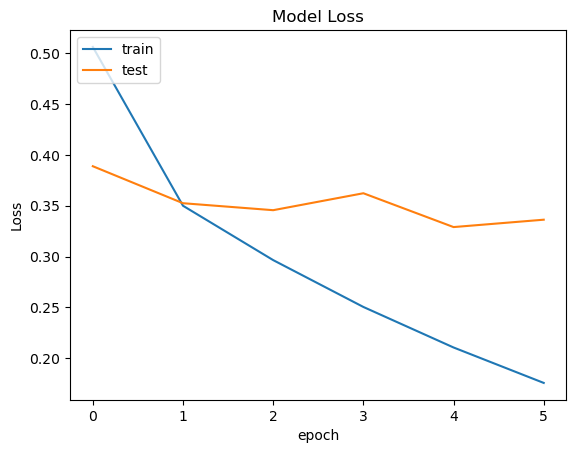

In [111]:
# Model performance Charts 
plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')


plt.show()

### Much Better AS Accurecy but still have an issue using cnn still there is an overfitting so lets try something else  

# We are going to use the LSTM (RUCURRENT NEURAL NETWORK)

In [112]:
# Neural Network Architecture 
LSTM_model=Sequential()

embedding_layar=Embedding(vocab_length,100,weights=[embedding_matrix],input_length=maxlen , trainable=False)
LSTM_model.add(embedding_layar)

LSTM_model.add(LSTM(128))
LSTM_model.add(Dense(1,activation='sigmoid'))


In [113]:
# Model Compile 
LSTM_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
print(LSTM_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          9085500   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9202877 (35.11 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9085500 (34.66 MB)
_________________________________________________________________
None


In [114]:
# Model Training 
LSTM_model_history=LSTM_model.fit(X_train,y_train,batch_size=128,epochs=6,verbose=1,validation_split=(0.2))

Epoch 1/6
250/250 [==============================] - 37s 141ms/step - loss: 0.5086 - acc: 0.7492 - val_loss: 0.4531 - val_acc: 0.8019
Epoch 2/6
250/250 [==============================] - 35s 142ms/step - loss: 0.4244 - acc: 0.8059 - val_loss: 0.3959 - val_acc: 0.8340
Epoch 3/6
250/250 [==============================] - 38s 151ms/step - loss: 0.3787 - acc: 0.8342 - val_loss: 0.3585 - val_acc: 0.8424
Epoch 4/6
250/250 [==============================] - 36s 143ms/step - loss: 0.3450 - acc: 0.8530 - val_loss: 0.3455 - val_acc: 0.8505
Epoch 5/6
250/250 [==============================] - 35s 141ms/step - loss: 0.3236 - acc: 0.8628 - val_loss: 0.3340 - val_acc: 0.8539
Epoch 6/6
250/250 [==============================] - 36s 142ms/step - loss: 0.3067 - acc: 0.8728 - val_loss: 0.3903 - val_acc: 0.8395


In [115]:
# prediction on testset 
score=LSTM_model.evaluate(X_test,y_test,verbose=1)

313/313 [==============================] - 6s 18ms/step - loss: 0.3881 - acc: 0.8368


In [116]:
#Model Performance 
print("Test score:" , score[0])
print("Test Accuracy:" , score[1])

Test score: 0.38814568519592285
Test Accuracy: 0.8367999792098999


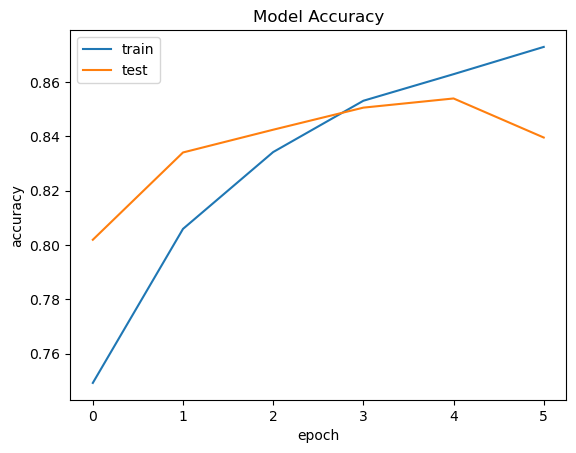

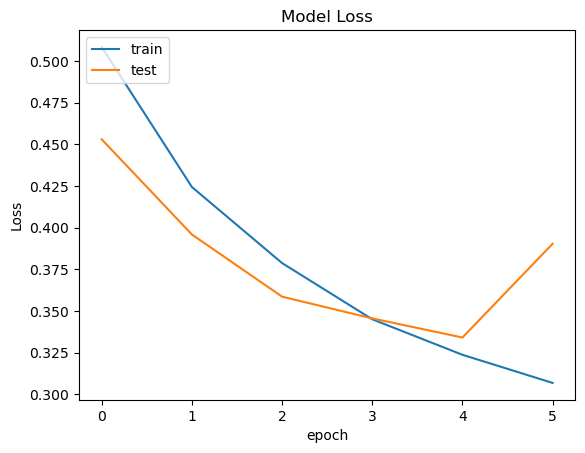

In [117]:
# Model performance Charts 
plt.plot(LSTM_model_history.history['acc'])
plt.plot(LSTM_model_history.history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

plt.plot(LSTM_model_history.history['loss'])
plt.plot(LSTM_model_history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')


plt.show()

# Much better ((':')') 


In [118]:
# Saving the model as h5 file for possible use later 
LSTM_model.save(f"./cl_lstm_model_acc_{round(score[1],3)}.h5" , save_format='h5')

c:\Users\HP\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Test it On Unseen Data 

In [119]:
sample_review=pd.read_csv('a3_IMDb_Unseen_Reviews.csv')
sample_review.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [121]:
# Do preprocess for the  Review Text with the earlier defiend preprocess 
unseen_review=sample_review['Review Text']
unseen_processed=[]
for review in unseen_review:
    review=preprocess_text(review)
    unseen_processed.append(review) 

In [122]:
#Tokenising instance with earlier traiend tokeniser 
unseen_tokenized=word_tokenizer.texts_to_sequences(unseen_processed)

#pooling instance to have maxlenght of 100 token 
unseen_padded=pad_sequences(unseen_tokenized,padding='post',maxlen=maxlen)

In [123]:
#passing tokenised instance to the lstm model from predection 
unseen_sentement=LSTM_model.predict(unseen_padded)
unseen_sentement

1/1 [==============================] - 0s 366ms/step


array([[0.5198481 ],
       [0.97435546],
       [0.34222108],
       [0.043487  ],
       [0.78014565],
       [0.02003042]], dtype=float32)

In [127]:
#writing this file on local file
sample_review['Predection_sentement']=np.round(unseen_sentement*10,1)
df_prediction_sentiments = pd.DataFrame(sample_review['Predection_sentement'],columns=['Predection_sentement'])
df_movie                =pd.DataFrame(sample_review['Movie'],columns=['Movie'])
df_Review_Text=pd.DataFrame(sample_review['Review Text'],columns=['Review Text'])
df_IMDb_Rating=pd.DataFrame(sample_review['IMDb Rating'],columns=['IMDb Rating'])

dfx=pd.concat([df_movie,df_Review_Text,df_IMDb_Rating,df_prediction_sentiments],axis=1)

dfx.to_csv('File_unseen.csv',sep=',',encoding='UTF-8')

dfx.head()


,Movie,Review Text,IMDb Rating,Predection_sentement
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,5.2
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.7
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,3.4
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,0.4
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,7.8
